In [4]:
import os 
import cv2
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#import matplotlib.image as Image
#import tensorflow as tf
#from skimage import transform
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score


# Data import & Pre-processing --------------------------------------------------------------------

In [5]:
# Gets paths for images 
def get_catalog(file):
    species = []
    pics = []
    for root, subdir, files in os.walk(file):
        species.append(subdir)
        pics.append(files)
    species = species[0]
    
    catalog = {}
    for i in range(len(species)):
        catalog[species[i]] = pics[i+1]
    return catalog

In [6]:
def data_augmentation(picture, save_loc,name):
    #flip_2 = tf.image.flip_up_down(picture)
    #cv2.imwrite(save_loc + name[:-4] + 'a.jpg', np.array(flip_2))
    #flip_3 = tf.image.flip_left_right(picture)
    #cv2.imwrite(save_loc + name[:-4] + 'b.jpg', np.array(flip_3))
    #flip_4 = tf.image.flip_up_down(flip_3)
    #cv2.imwrite(save_loc + name[:-4] + 'c.jpg', np.array(flip_4))
    if len(name) == 7:
        #rot_90 = tf.image.rot90(picture, k=1)
        #cv2.imwrite(save_loc + name[:-4] + 'd.jpg', np.array(rot_90))
        #rot_180 = tf.image.rot90(picture, k=3)
        #cv2.imwrite(save_loc + name[:-4] + 'e.jpg', np.array(rot_180))
        #'here'
        #rot_2 = tf.image.rot90(flip_3, k=1)
        #cv2.imwrite(save_loc + name[:-4] + 'f.jpg', np.array(rot_2))
        #rot_3 = tf.image.rot90(flip_3, k=3)
        #cv2.imwrite(save_loc + name[:-4] + 'g.jpg', np.array(rot_3))
        #below used
        #rot = transform.rotate(picture, angle=45, mode='reflect')
        #cv2.imwrite(save_loc + name[:-4] + 'h.jpg', (np.array(rot)*255).astype(np.uint8))
        print('heretoo')
       #rot1 = transform.rotate(rot, angle=90, mode='reflect')
       #plt.imshow(rot1)
       #plt.show()
       #rot2 = transform.rotate(rot1, angle=90, mode='reflect')
       #plt.imshow(rot2)
       #plt.show()
       #rot3 = transform.rotate(rot2, angle=90, mode='reflect')
       #plt.imshow(rot3)
       #plt.show()

In [7]:
def get_pics(catalog,path, species_index,pic_index, size):
    count = 1
    new_catalog = {}
    names = []
    for specie in catalog:
        images =[]
        for i in range(pic_index):
            image = cv2.imread(path + specie + '/' + catalog[specie][i])
            #data_augmentation(image,path + specie + '/',catalog[specie][i])
            res = cv2.resize(image, dsize=size, interpolation=cv2.INTER_NEAREST)
            images.append(res.flatten())
        new_catalog[specie] = np.array(images)
        names.append(specie[1:])
        if count == species_index:
            break
        count += 1
        
    return new_catalog, names

In [8]:
def import_pics2(path, nspec, npic,shape):
    bird_catalog = get_catalog(path)
    pics, spec_names = get_pics(bird_catalog,path, nspec, npic,shape)
    return pics, spec_names

In [9]:
def get_Xy(pictures):
    test_images = []
    labels = []
    count = 0
    for species, values in pictures.items():
        if len(test_images) == 0:
            test_images = values
            labels = np.repeat(count,values.shape[0])
        else:
            test_images = np.concatenate((test_images,values),axis=0)
            labels = np.concatenate((labels, np.repeat(count, values.shape[0])),axis=0)
        count +=1
    test_images = np.array(test_images)
    return test_images, np.array(labels)

In [10]:
def dim_reduction(X):
    X = StandardScaler().fit_transform(X)
    pca = PCA(random_state=seed).fit(X)
    new_X = pca.transform(X)
    print("Dim reduction ready.")
    return new_X, pca

In [11]:
def dim_reduction_kernelcosine(X):
    X = StandardScaler().fit_transform(X)
    kpca = KernelPCA(kernel='cosine',random_state=seed).fit(X)
    new_X = kpca.transform(X)
    print("Kernel PCA cosine ready")
    return new_X, kpca

In [ ]:
# Main function for data preprocessing ----------------------------------------------------------------------------------
seed = 2
np.random.RandomState(seed)

#Declare variables 
train_file, valid_file, test_file = 'data/birds/train/', 'data/birds/valid/', 'data/birds/test/'
num_species = 8
num_pics_train, num_pics_val, num_pics_test = 840, 5, 5
size = (64,64)

#get pictures
train_pictures, species_names = import_pics2(train_file, num_species, num_pics_train,size)
valid_pictures, _ = import_pics2(valid_file, num_species, num_pics_val,size)
test_pictures, _ = import_pics2(test_file, num_species, num_pics_test,size)

In [13]:
print(species_names)
species_names[0] = 'BLACK BROADBILL'
species_names[6] ='GROUND HORNBILL'
#species_names[7] = 'CROWNED CRANE'
#species_names[10] = 'EMERALD CUCKOO'
#species_names[8] = 'FIREFINCH'
#species_names[12] = 'OYSTER CATCHER'
print(species_names)

['BLACK YELLOW BROADBILL', 'FLAMINGO', 'BALD EAGLE', 'ANNAS HUMMINGBIRD', 'SCARLET MACAW', 'TOUCHAN', 'ABYSSINIAN GROUND HORNBILL']
['BLACK BROADBILL', 'FLAMINGO', 'BALD EAGLE', 'ANNAS HUMMINGBIRD', 'SCARLET MACAW', 'TOUCHAN', 'GROUND HORNBILL']


# Dimensionality Reduction -------------------------------------------------------------------------

In [14]:
def eigendecomposition(images):
    species_values = {}
    for specie, values in images.items():
        mean = np.mean(values,axis=0)
        x = (values-mean)/ 255
        U, S, V = np.linalg.svd(x.T,full_matrices=False)
        species_values[specie] = [U, S, mean, x]
    print("Done eigendecomposing.")
    return species_values

In [15]:
def plot_variance(catalog,n_spec):
    count = 0
    for spec, vals in catalog.items():
        eigenvalues = np.sum(np.diag(vals[1]),axis=0)
        total = np.sum(eigenvalues)
        eigenvalues_norm = eigenvalues/total
        
        meanbird = np.reshape(vals[2],(1,12288))
        meanbird = np.reshape(meanbird.astype(np.uint8),(64,64,3))
        plt.imshow(meanbird)
        plt.show()
        cv2.imwrite('plots/meanbird-{}.jpg'.format(spec[1:4]), np.array(meanbird))
        
        eigenbird = np.reshape(vals[0][:,2],(1,12288))
        eigenbird = np.reshape(((eigenbird * 255)).astype(np.uint8),(64,64,3))
        plt.imshow(eigenbird)
        plt.show()
        cv2.imwrite('plots/eigenbird-{}.jpg'.format(spec[1:4]), eigenbird)
        
        plt.scatter(np.arange(0, eigenvalues.shape[0]), eigenvalues_norm*100)
        plt.title(spec[1:])
        plt.xlabel('Principal Components')
        plt.ylabel('Variance percentage')
        plt.savefig('plots/variance-{}.jpg'.format(spec[1:4]))
        plt.grid()
        plt.show()
        count += 1
        if count == n_spec:
            break

In [16]:
def get_eigenspecies(eigen,n_comp):
    species_eigenvectors = {}
    for spec, vals in  eigen.items():
        U = vals[0]
        mean = vals[2]
        x = vals[3]
        eigenvs =  U[:,:n_comp]
        species_eigenvectors[spec] = (eigenvs, mean, x)
    print("Done getting eigenspecies.")
    return species_eigenvectors

In [17]:
def get_residuals(eigenspecies,test):
    residuals_matrix = []
    test = test / 255
    matrix_residual = []
    for image in test:
        per_species_residual = []
        for specie, metrics in eigenspecies.items():
            pre_image = image - (metrics[1]/255)
            residual = np.linalg.norm(pre_image - (metrics[0] @ metrics[0].T @ pre_image))**2
            per_species_residual.append(residual)
        matrix_residual.append(per_species_residual) 
    print("Done getting residuals.")
    return np.array(matrix_residual)

In [18]:
start = time.time()
eigenvectors = eigendecomposition(train_pictures)

Done eigendecomposing.


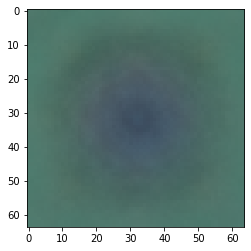

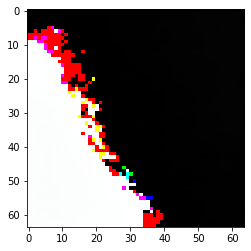

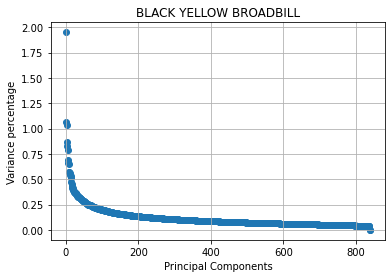

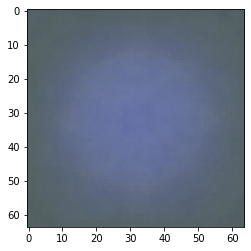

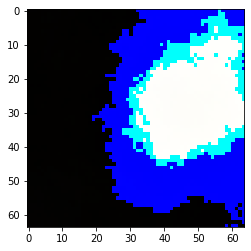

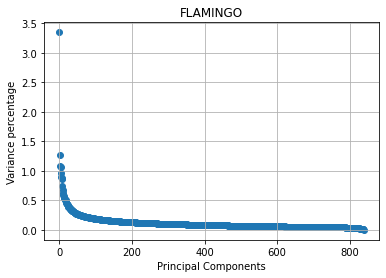

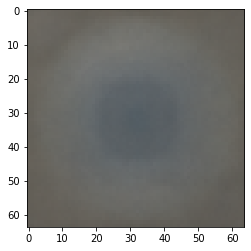

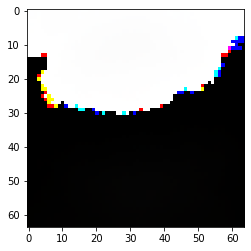

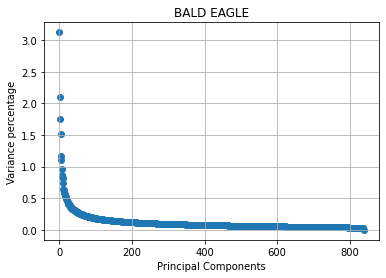

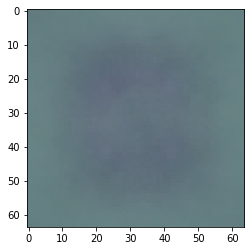

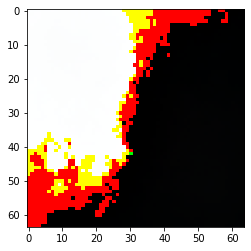

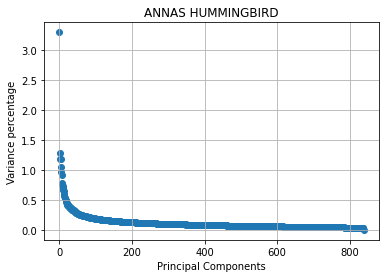

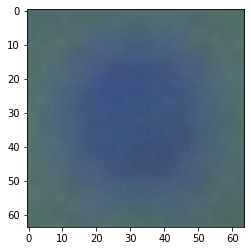

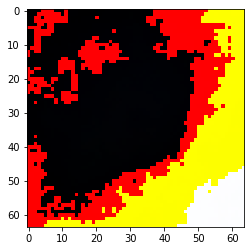

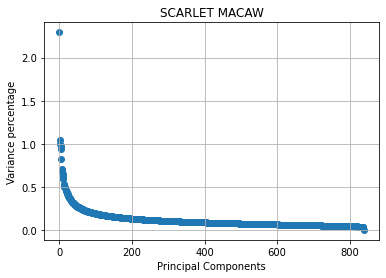

In [19]:
plot_variance(eigenvectors,5)

In [20]:
eigenspecies = get_eigenspecies(eigenvectors, 180)
X_test, y_test = get_Xy(test_pictures)
residuals = get_residuals(eigenspecies,X_test)
end = time.time()
print(end-start)


Done getting eigenspecies.
Done getting residuals.
577.2994329929352


0.8571428571428571
                   precision    recall  f1-score   support

  BLACK BROADBILL       0.80      0.80      0.80         5
         FLAMINGO       1.00      1.00      1.00         5
       BALD EAGLE       0.83      1.00      0.91         5
ANNAS HUMMINGBIRD       0.62      1.00      0.77         5
    SCARLET MACAW       1.00      1.00      1.00         5
          TOUCHAN       1.00      1.00      1.00         5
  GROUND HORNBILL       1.00      0.20      0.33         5

         accuracy                           0.86        35
        macro avg       0.89      0.86      0.83        35
     weighted avg       0.89      0.86      0.83        35



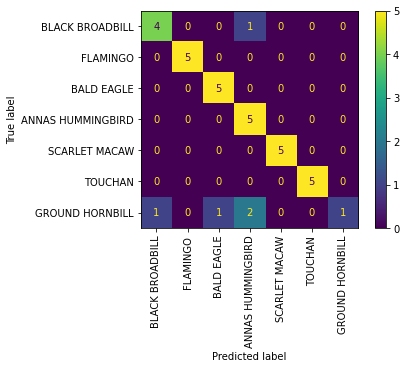

In [21]:
classification = residuals.argmin(axis=1)
print(accuracy_score(y_test,classification))
print(classification_report(y_test,classification,target_names=species_names))

cf_matrix = confusion_matrix(y_test,classification)
cf = ConfusionMatrixDisplay(cf_matrix, display_labels= species_names)
cf.plot(xticks_rotation='vertical')
plt.savefig('plots/dim-red-cf.jpg')
plt.show()

# Density Estimation -----------------------------------------------------------------------------------

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# Assign cluster label to classification label. 
def retrieve_info(cluster_labels,y_train):
    reference_labels = {}
    for i in range(len(np.unique(cluster_labels))):
        index = np.where(cluster_labels == i,1,0)
        num = np.bincount(y_train[index==1]).argmax()
        reference_labels[i] = num
    return reference_labels

In [ ]:
# Build Kmeans model and dictionary of labels. 
def k_means(seed,num_clust,X,y):
    clf_km = KMeans(n_clusters=num_clust,random_state=seed).fit(X)
    map_kmlabels = retrieve_info(clf_km.labels_,y)
    return map_kmlabels, clf_km

In [ ]:
X_train, y_train = get_Xy(train_pictures)
X_val, y_val = get_Xy(valid_pictures)
X_test, y_test = get_Xy(test_pictures)

#scale_X_train, kpc = dim_reduction_kernelcosine(X_train)
#scale_X_val = kpc.transform(X_val)
#scale_X_test = kpc.transform(X_test)

scale_X_train, scale_X_val, scale_X_test = (X_train/255).astype('float32'), (X_val/255).astype('float32'), (X_test/255).astype('float32')

In [ ]:
print(scale_X_train.shape)

In [ ]:
# do not run
accuracy = []
cluster = np.arange(175,205,5)

start = time.time()
for i in cluster:
    mapping, model = k_means(seed, i, scale_X_train, y_train)
    pred = model.predict(scale_X_val)
    translated_pred = [mapping[i] for i in pred]
    accuracy.append(accuracy_score(translated_pred, y_test))
    print('Iteration ' + str(i) + " complete.")
end = time.time()

print(end-start)

In [ ]:
plt.plot(cluster, accuracy)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Model Validation by Number of Clusters')
plt.savefig('plots/den-est-valid2.jpg')
plt.show()

In [ ]:
mapping, model = k_means(seed, int(np.sqrt(scale_X_train.shape[0]/2)), scale_X_train, y_train)
pred1 = model.predict(scale_X_train)
pred2 = model.predict(scale_X_test)
translated_pred1 = [mapping[i] for i in pred1]
translated_pred2 = [mapping[i] for i in pred2]

In [ ]:
print(classification_report(y_train,translated_pred1,target_names=species_names))
print(classification_report(y_test,translated_pred2,target_names=species_names))
print(model.inertia_)

cf_matrix = confusion_matrix(y_test,translated_pred2)
cf = ConfusionMatrixDisplay(cf_matrix, display_labels= species_names)
cf.plot(xticks_rotation='vertical')
plt.savefig('plots/den-est-cf.jpg')
plt.show()

# Traditional Classification --------------------------------------------------------------------------

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [12]:
def train_model(X, label):
    cvs = []
    start = time.time()
    knn = KNeighborsClassifier()
    n_neighbors = {'n_neighbors': list(range(2,10))}
    clf_knn = GridSearchCV(knn,n_neighbors).fit(X,label)
    cvs.append(clf_knn)
    print("KNN done")
    print("Time: {0:.2f} seconds\nBest accuracy:{1:.2f}, Estimator: {2}\n".format(time.time()-start,clf_knn.best_score_,clf_knn.best_estimator_))
    
    start = time.time()
    svm = SVC(kernel='linear')
    kernel = {'C': [0.1, 1, 2, 4, 10, 100]}
    clf_svm = GridSearchCV(svm,kernel).fit(X,label)
    cvs.append(clf_svm)
    print("linear SVM done.")
    print("Time: {0:.2f} seconds\nBest accuracy: {1:.2f}, Estimator: {2}\n".format(time.time()-start,clf_svm.best_score_,clf_svm.best_estimator_))
    
    start = time.time()
    svm = SVC(kernel='rbf')
    kernel = {'C': [0.1, 1, 2, 4, 10, 100]}
    clf_svm = GridSearchCV(svm,kernel).fit(X,label)
    cvs.append(clf_svm)
    print("Kernel SVM done.")
    print("Time: {0:.2f} seconds\nBest accuracy: {1:.2f}, estimator: {2}\n".format(time.time()-start,clf_svm.best_score_,clf_svm.best_estimator_))
    
    start = time.time()
    lr = LogisticRegression(max_iter=10000,random_state=seed)
    acc_score_lr = np.mean(cross_val_score(lr,X,label,cv=5))
    cvs.append(acc_score_lr)
    print("LR done")
    print("Time: {0:.2f} seconds\nBest accuracy: {1:.2f}\n".format(time.time()-start,acc_score_lr))
    
    return cvs

In [13]:
X, y = get_Xy(train_pictures)
X, kpca = dim_reduction_kernelcosine(X)
print(X.shape,'\n')
cv_grid = train_model(X, y)

Kernel PCA cosine ready
(8400, 8396) 

KNN done
Time: 173.81 seconds
Best accuracy:0.36, Estimator: KNeighborsClassifier()

linear SVM done.
Time: 6334.30 seconds
Best accuracy: 0.49, Estimator: SVC(C=2, kernel='linear')

Kernel SVM done.
Time: 10133.77 seconds
Best accuracy: 0.60, estimator: SVC(C=10)

LR done
Time: 216.19 seconds
Best accuracy: 0.47



In [ ]:
X2, y2 = get_Xy(train_pictures)
X2, pca = dim_reduction(X2)
cv_grid = train_model(X2, y2)

# Deep Learning -----------------------------------------------------------------------------------------

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def deep_pre_process(image_catalog, og_shape):
    X, y = get_Xy(image_catalog)
    tenso_X = np.reshape(X,(X.shape[0], og_shape[0], og_shape[1], 3))
    tenso_X = tenso_X.astype('float32')
    tenso_X = tenso_X / 255.
    
    y_one_hot = to_categorical(y)
    return tenso_X, y_one_hot
    

In [ ]:
X_train, y_train = deep_pre_process(train_pictures, size)
X_val, y_val = deep_pre_process(valid_pictures, size)
X_test, y_test = deep_pre_process(test_pictures, size)

## Neural Network implementation 

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_model(shape,classes):
    bird_model = Sequential()
    bird_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(shape[1],shape[2],shape[3]),padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))
    bird_model.add(MaxPooling2D((2, 2),padding='same'))
    bird_model.add(Dropout(0.25))
    bird_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))
    bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    bird_model.add(Dropout(0.25))
    bird_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    bird_model.add(LeakyReLU(alpha=0.1))                  
    bird_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    bird_model.add(Dropout(0.4))
    bird_model.add(Flatten())
    bird_model.add(Dense(128, activation='linear'))
    bird_model.add(LeakyReLU(alpha=0.1))           
    bird_model.add(Dropout(0.3))
    bird_model.add(Dense(classes, activation='softmax'))
    
    bird_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(),metrics=['accuracy'])
    print(bird_model.summary())
    return bird_model

In [ ]:
batch_size = 64
epochs = 20
num_classes = num_species

In [ ]:
clf_cnn = build_model(X_train.shape, num_classes)

In [ ]:
bird_train = clf_cnn.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val))

In [ ]:
accuracy = bird_train.history['accuracy']
val_accuracy = bird_train.history['val_accuracy']
loss = bird_train.history['loss']
val_loss = bird_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.legend()
plt.savefig('plots/cnn-accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig('plots/cnn-loss.jpg')
plt.show()

In [ ]:
test_eval = clf_cnn.evaluate(X_test, y_test, verbose=0)
prediction = np.argmax(clf_cnn.predict(X_test),axis=1)
true_y = np.argmax(y_test,axis=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1], '\n')

print(classification_report(true_y,prediction,target_names=species_names))

cf_matrix_cnn = confusion_matrix(true_y,prediction)
cf_cnn = ConfusionMatrixDisplay(cf_matrix_cnn, display_labels= species_names)
cf_cnn.plot(xticks_rotation='vertical')
plt.savefig('plots/deep-learn-cf.jpg')
plt.show()